--- Training DenseNet-121 on COVID-19 Radiography Dataset | Device: cuda ---
Data Loaded: 16932 train images and 4233 validation images.

Class distribution in training set:
Label
Normal             8154
Lung_Opacity       4809
COVID              2893
Viral Pneumonia    1076
Name: count, dtype: int64


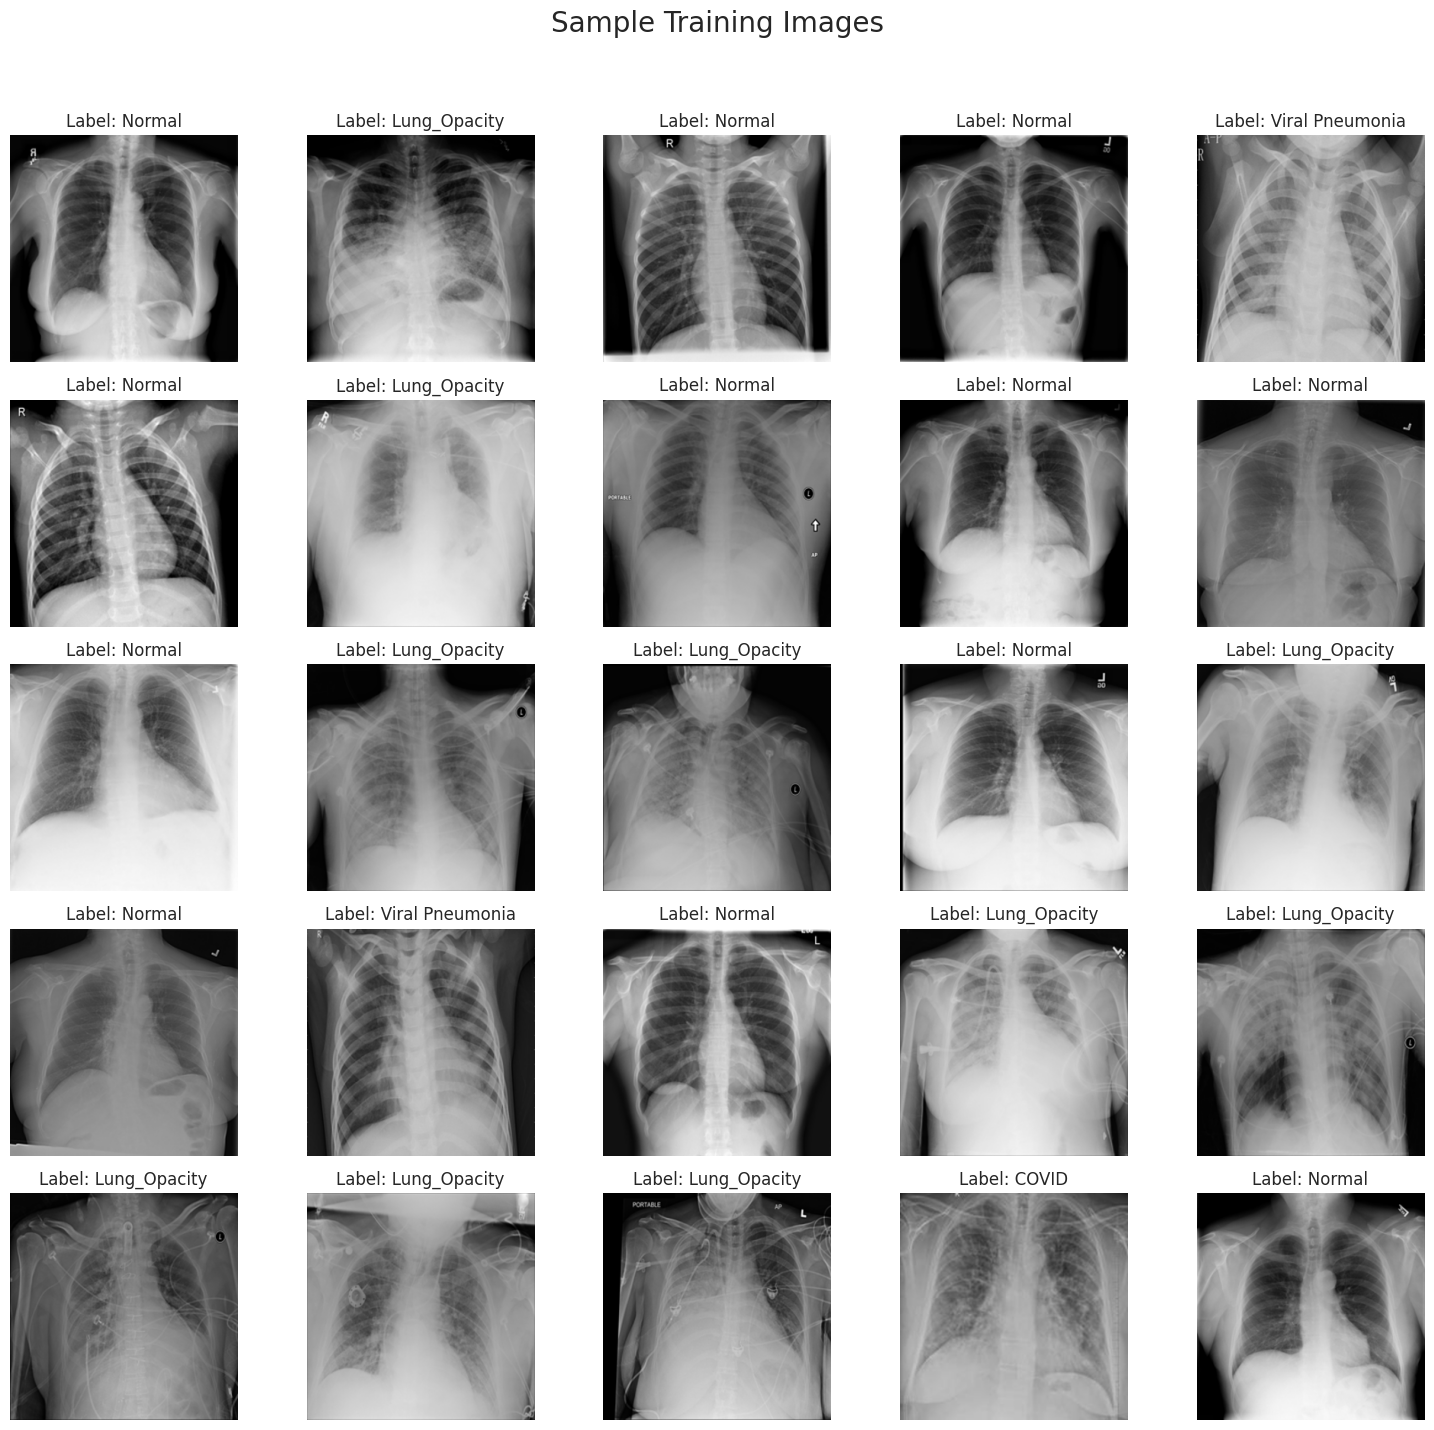


--- Epoch 1/10 ---


Evaluating: 100%|██████████| 133/133 [00:13<00:00, 10.06it/s]


Epoch 1: Train Loss: 0.3570 | Train Acc: 0.8720 | Val Loss: 0.1821 | Val Acc: 0.9412
Validation loss improved (inf --> 0.1821). Saving model...

--- Epoch 2/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.39it/s]


Epoch 2: Train Loss: 0.1958 | Train Acc: 0.9311 | Val Loss: 0.1485 | Val Acc: 0.9459
Validation loss improved (0.1821 --> 0.1485). Saving model...

--- Epoch 3/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.32it/s]


Epoch 3: Train Loss: 0.1597 | Train Acc: 0.9441 | Val Loss: 0.1626 | Val Acc: 0.9490

--- Epoch 4/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.47it/s]


Epoch 4: Train Loss: 0.1398 | Train Acc: 0.9525 | Val Loss: 0.1450 | Val Acc: 0.9494
Validation loss improved (0.1485 --> 0.1450). Saving model...

--- Epoch 5/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.81it/s]


Epoch 5: Train Loss: 0.1246 | Train Acc: 0.9571 | Val Loss: 0.1255 | Val Acc: 0.9587
Validation loss improved (0.1450 --> 0.1255). Saving model...

--- Epoch 6/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.97it/s]


Epoch 6: Train Loss: 0.1126 | Train Acc: 0.9607 | Val Loss: 0.1262 | Val Acc: 0.9615

--- Epoch 7/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.38it/s]


Epoch 7: Train Loss: 0.1076 | Train Acc: 0.9619 | Val Loss: 0.1285 | Val Acc: 0.9570

--- Epoch 8/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.37it/s]


Epoch 8: Train Loss: 0.0948 | Train Acc: 0.9685 | Val Loss: 0.1486 | Val Acc: 0.9551

--- Epoch 9/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.64it/s]


Epoch 9: Train Loss: 0.0616 | Train Acc: 0.9801 | Val Loss: 0.1379 | Val Acc: 0.9579

--- Epoch 10/10 ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.71it/s]


Epoch 10: Train Loss: 0.0470 | Train Acc: 0.9847 | Val Loss: 0.1311 | Val Acc: 0.9601


--- 📈 Final Evaluation on VALIDATION SET ---
--- Loaded best model from best_model_covid.pth for final evaluation. ---


Evaluating: 100%|██████████| 133/133 [00:12<00:00, 10.60it/s]


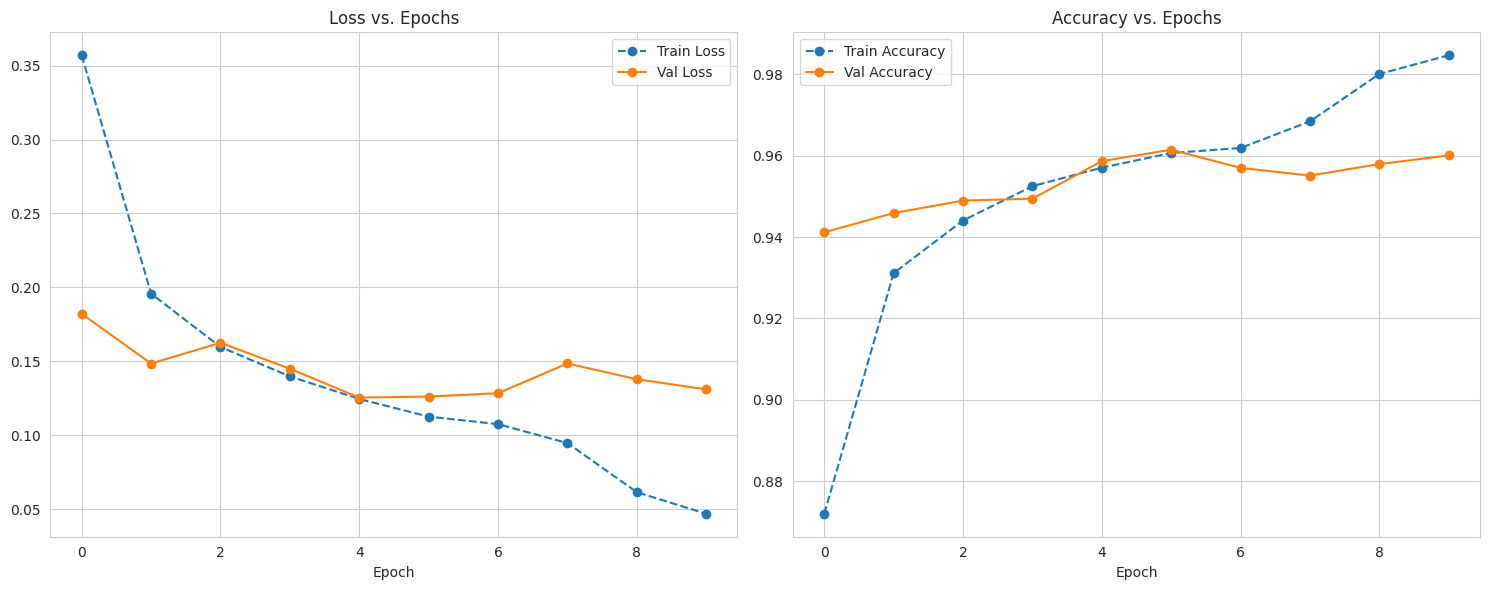

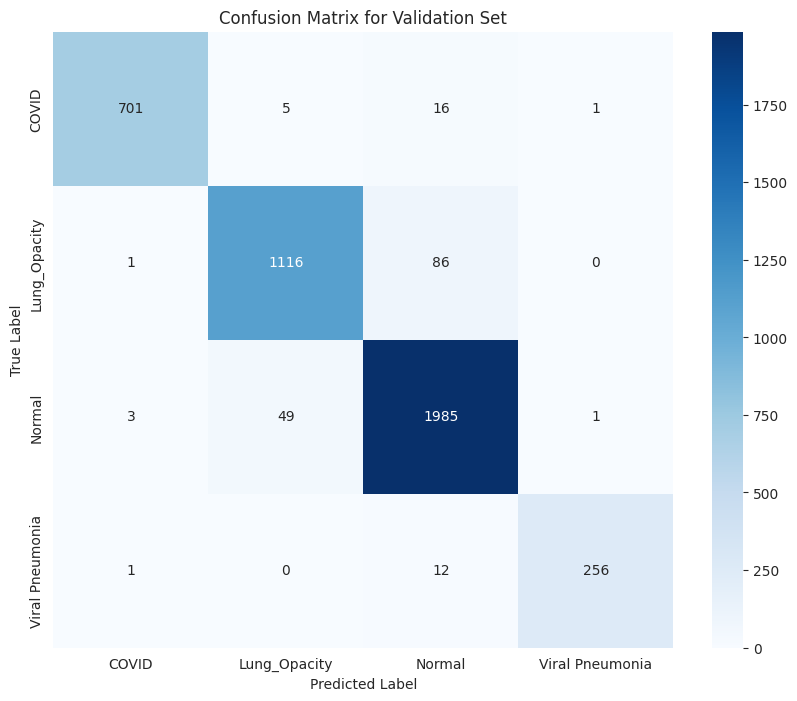


   Final Classification Report
                 precision    recall  f1-score   support

          COVID       0.99      0.97      0.98       723
   Lung_Opacity       0.95      0.93      0.94      1203
         Normal       0.95      0.97      0.96      2038
Viral Pneumonia       0.99      0.95      0.97       269

       accuracy                           0.96      4233
      macro avg       0.97      0.96      0.96      4233
   weighted avg       0.96      0.96      0.96      4233



--- 🧠 Performing XAI Analysis (Grad-CAM) ---


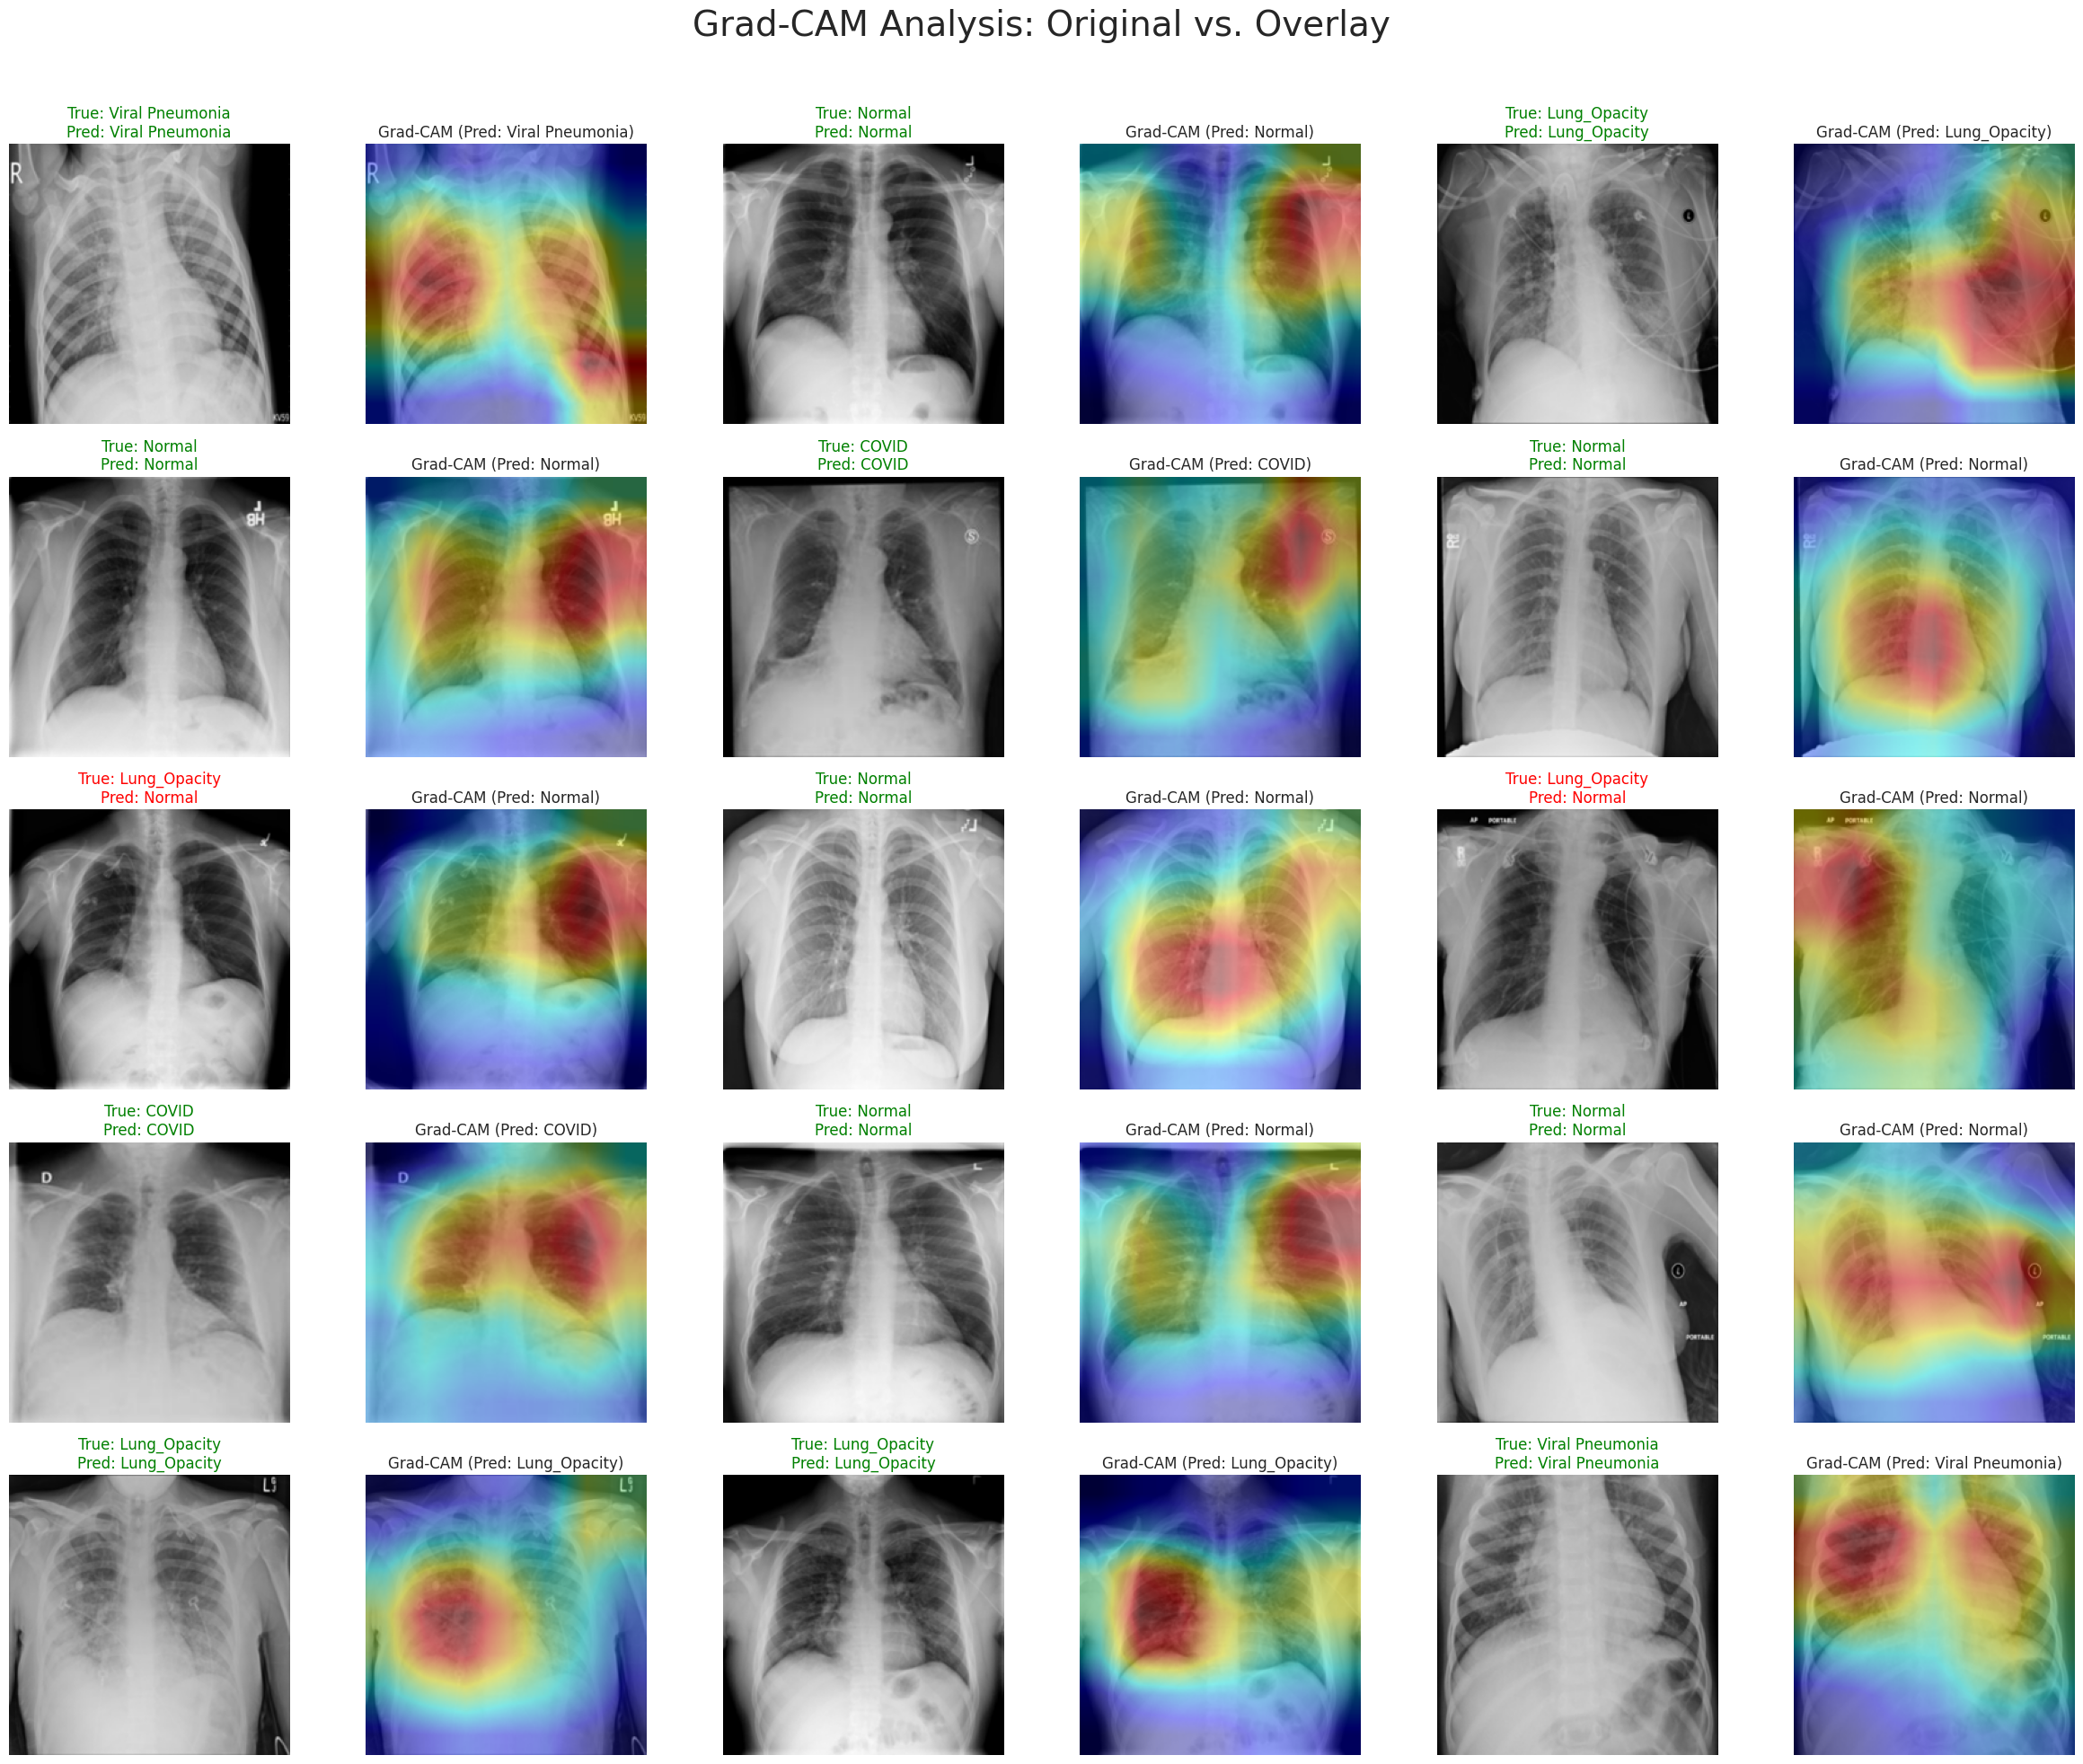

In [11]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision import models
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import albumentations as A
from albumentations.pytorch import ToTensorV2
from captum.attr import LayerGradCam
import torch.nn.functional as F

# Suppress warnings and set plot style
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# ==============================================================================
# 2. CONFIGURATION
# ==============================================================================
CONFIG = {
    "DATASET_DIR": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset",
    "IMAGE_SIZE": 224,
    "BATCH_SIZE": 32,
    "NUM_EPOCHS": 10,
    "LEARNING_RATE": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "SEED": 42,
    "DROPOUT_RATE": 0.5,
    "NUM_CLASSES": 4,
    "CLASSES": ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
}

# Set seed for reproducibility
torch.manual_seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])

# ==============================================================================
# 3. DATA HANDLING & VISUALIZATION
# ==============================================================================
def create_covid_df(dataset_dir):
    data = []
    class_to_int = {class_name: i for i, class_name in enumerate(CONFIG['CLASSES'])}
    
    for class_name in CONFIG['CLASSES']:
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            print(f"Warning: Directory not found for class '{class_name}' at {class_path}")
            continue
            
        # --- CORRECTED PATH ---
        # Only search for images within the 'images' subdirectory of each class
        images_path = os.path.join(class_path, "images")
        image_files = glob.glob(os.path.join(images_path, "*.png"))
        label = class_to_int[class_name]
        
        for img_path in image_files:
            data.append({'ImagePath': img_path, 'Label': label})
            
    df = pd.DataFrame(data)
    if df.empty:
        raise FileNotFoundError(f"No .png files found in the 'images' subdirectories of {dataset_dir}. Please check your path and folder structure.")
        
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=CONFIG['SEED'], stratify=df['Label'])
    train_df['Split'] = 'train'
    val_df['Split'] = 'val'
    
    full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
    return full_df

def visualize_data_grid(df, title="Sample Training Images"):
    sample_df = df.sample(min(25, len(df))).reset_index(drop=True)
    plt.figure(figsize=(15, 15))
    plt.suptitle(title, fontsize=20)
    int_to_class = {i: class_name for i, class_name in enumerate(CONFIG['CLASSES'])}
    for i, row in sample_df.iterrows():
        plt.subplot(5, 5, i + 1)
        img = cv2.imread(row['ImagePath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = int_to_class[row['Label']]
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def get_transforms(image_size):
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    train_transform = A.Compose([
        A.Resize(image_size, image_size), A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2()
    ])
    val_transform = A.Compose([
        A.Resize(image_size, image_size), A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD), ToTensorV2()
    ])
    return train_transform, val_transform

class CovidDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.labels = df['Label'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'ImagePath']
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        original_image = cv2.resize(image, (CONFIG["IMAGE_SIZE"], CONFIG["IMAGE_SIZE"]))
        
        if self.transform:
            image_tensor = self.transform(image=image)['image']
        else:
            image_tensor = A.Compose([
                A.Resize(CONFIG["IMAGE_SIZE"], CONFIG["IMAGE_SIZE"]),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])(image=image)['image']
            
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image_tensor, label, original_image

# ==============================================================================
# 4. MODEL DEFINITION (Adapted for Multi-Class)
# ==============================================================================
def get_model(num_classes, pretrained=True, dropout_rate=0.5):
    model = models.densenet121(weights='IMAGENET1K_V1' if pretrained else None)
    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout_rate),
        nn.Linear(in_features, num_classes)
    )
    return model

# ==============================================================================
# 5. ENGINE & PLOTTING (Adapted for Multi-Class)
# ==============================================================================
def train_one_epoch(model, train_loader, optimizer, criterion, device, scaler):
    model.train(); total_loss = 0.0; all_preds, all_true = [], []
    for images, labels, _ in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        total_loss += loss.item()
        
        preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
        all_preds.extend(preds); all_true.extend(labels.cpu().numpy())
        
    accuracy = accuracy_score(all_true, all_preds)
    return total_loss / len(train_loader), accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval(); total_loss = 0.0; all_preds, all_true = [], []
    with torch.no_grad():
        for images, labels, _ in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            with autocast():
                outputs = model(images); loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds); all_true.extend(labels.cpu().numpy())
            
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_true, all_preds)
    return avg_loss, accuracy, np.array(all_preds), np.array(all_true)

def plot_history(history):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], 'o--', label='Train Loss'); plt.plot(history['val_loss'], 'o-', label='Val Loss')
    plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], 'o--', label='Train Accuracy'); plt.plot(history['val_acc'], 'o-', label='Val Accuracy')
    plt.title('Accuracy vs. Epochs'); plt.xlabel('Epoch'); plt.legend()
    plt.tight_layout(); plt.show()

def plot_confusion_matrices(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CONFIG['CLASSES'], yticklabels=CONFIG['CLASSES'])
    plt.title('Confusion Matrix for Validation Set'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()

def print_classification_report(y_true, y_pred):
    print("\n" + "="*50 + "\n   Final Classification Report\n" + "="*50)
    report = classification_report(y_true, y_pred, target_names=CONFIG['CLASSES'], zero_division=0)
    print(report)
    print("="*50 + "\n")

# ==============================================================================
# 6. XAI ANALYSIS (GRAD-CAM for Multi-Class)
# ==============================================================================
def generate_gradcam_overlay(image_tensor, original_image, model, target_layer, target_class):
    model.eval()
    input_tensor = image_tensor.unsqueeze(0).to(CONFIG['DEVICE'])
    lgc = LayerGradCam(model, target_layer)
    attribution = lgc.attribute(input_tensor, target=target_class)
    heatmap = F.interpolate(attribution, size=(original_image.shape[0], original_image.shape[1]), mode='bilinear', align_corners=False)
    heatmap_np = heatmap.squeeze().cpu().detach().numpy()
    heatmap_np = (heatmap_np - np.min(heatmap_np)) / (np.max(heatmap_np) - np.min(heatmap_np) + 1e-8)
    heatmap_uint8 = np.uint8(255 * heatmap_np)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlayed_image = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)
    return overlayed_image

def xai_analysis(model, data_loader, device):
    print("\n--- 🧠 Performing XAI Analysis (Grad-CAM) ---")
    model.eval()
    images_tensor, labels, original_images_np = next(iter(data_loader))
    target_layer = model.features.denseblock4
    
    outputs = model(images_tensor.to(device))
    preds = torch.argmax(outputs, dim=1).cpu()

    num_samples_to_show = 15
    fig, axes = plt.subplots(5, 6, figsize=(24, 20))
    fig.suptitle('Grad-CAM Analysis: Original vs. Overlay', fontsize=28)
    int_to_class = {i: class_name for i, class_name in enumerate(CONFIG['CLASSES'])}

    for i in range(num_samples_to_show):
        if i >= len(images_tensor): break
        
        row = i // 3
        base_col = (i % 3) * 2
        
        ax_orig = axes[row, base_col]
        ax_grad = axes[row, base_col + 1]

        image_tensor = images_tensor[i]
        original_image = original_images_np[i].numpy()
        true_label_idx = labels[i].item()
        pred_label_idx = preds[i].item()
        
        overlay = generate_gradcam_overlay(image_tensor, original_image, model, target_layer, pred_label_idx)
        
        true_text = int_to_class[true_label_idx]
        pred_text = int_to_class[pred_label_idx]
        color = "green" if true_label_idx == pred_label_idx else "red"
        ax_orig.imshow(original_image)
        ax_orig.set_title(f"True: {true_text}\nPred: {pred_text}", color=color, fontsize=12)
        ax_orig.axis('off')

        ax_grad.imshow(overlay)
        ax_grad.set_title(f"Grad-CAM (Pred: {pred_text})", fontsize=12)
        ax_grad.axis('off')
        
    for i in range(num_samples_to_show, 15):
        row = i // 3
        base_col = (i % 3) * 2
        if base_col < 6: axes[row, base_col].axis('off')
        if base_col + 1 < 6: axes[row, base_col + 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ==============================================================================
# 7. MAIN EXECUTION SCRIPT
# ==============================================================================
if __name__ == '__main__':
    training_successful = False
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    try:
        print(f"--- Training DenseNet-121 on COVID-19 Radiography Dataset | Device: {CONFIG['DEVICE']} ---")
        full_df = create_covid_df(CONFIG['DATASET_DIR'])
        train_df = full_df[full_df['Split'] == 'train']
        val_df = full_df[full_df['Split'] == 'val']
        print(f"Data Loaded: {len(train_df)} train images and {len(val_df)} validation images.")
        
        print("\nClass distribution in training set:")
        print(train_df['Label'].map({i: c for i, c in enumerate(CONFIG['CLASSES'])}).value_counts())
        
        visualize_data_grid(train_df)
        
        train_transform, val_transform = get_transforms(CONFIG["IMAGE_SIZE"])
        train_loader = DataLoader(CovidDataset(train_df, transform=train_transform), batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(CovidDataset(val_df, transform=val_transform), batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2, pin_memory=True)
        
        model = get_model(CONFIG['NUM_CLASSES'], dropout_rate=CONFIG['DROPOUT_RATE']).to(CONFIG['DEVICE'])
        
        criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        scaler = torch.cuda.amp.GradScaler()
        
        best_val_loss = float('inf')
        for epoch in range(CONFIG['NUM_EPOCHS']):
            print(f"\n--- Epoch {epoch+1}/{CONFIG['NUM_EPOCHS']} ---")
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, CONFIG['DEVICE'], scaler)
            val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, CONFIG['DEVICE'])
            
            history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
            scheduler.step(val_loss)
            
            if val_loss < best_val_loss:
                print(f"Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
                torch.save(model.state_dict(), 'best_model_covid.pth')
                best_val_loss = val_loss
        training_successful = True
        
    except Exception as e:
        print(f"\nAn error occurred: {e}")

    finally:
        if training_successful:
            print("\n\n--- 📈 Final Evaluation on VALIDATION SET ---")
            model_path = 'best_model_covid.pth'
            if os.path.exists(model_path):
                criterion = nn.CrossEntropyLoss()
                model = get_model(CONFIG['NUM_CLASSES'], pretrained=False, dropout_rate=CONFIG['DROPOUT_RATE']).to(CONFIG['DEVICE'])
                model.load_state_dict(torch.load(model_path))
                print(f"--- Loaded best model from {model_path} for final evaluation. ---")
                
                _, _, y_pred_val, y_true_val = evaluate(model, val_loader, criterion, CONFIG['DEVICE'])
                
                plot_history(history)
                plot_confusion_matrices(y_true_val, y_pred_val)
                print_classification_report(y_true_val, y_pred_val)
                xai_analysis(model, val_loader, CONFIG['DEVICE'])
            else:
                print("--- No model was saved. Skipping final evaluation. ---")
        else:
            print("\n--- Training was interrupted or failed. Skipping final evaluation. ---")